In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
# get the data
filname = 'train.csv'
label_map = ['Not Survived', 'Survived']
names=['Survived', 'Pclass', 'Name', 'Gender', 'Age', 'SibSp', 'Parch', 'Embarked']
df=pd.read_csv('train.csv',names=names, na_filter=False)
df.head(10)

,Survived,Pclass,Name,Gender,Age,SibSp,Parch,Embarked
0,Survived,Pclass,Name,Gender,Age,SibSp,Parch,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,S
6,0,3,"Moran, Mr. James",male,,0,0,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,S


In [33]:
def getData(filname):
    # images are 48x48
    # N = 35882
    Y = []
    X = []
    first = True
    i = 0
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            assert(len(row) == 9)
            
            Y.append(int(row[0]))
            
            X.append(list())
            
            X[i].append(int(row[1]) / 3)
            if row[4] == 'male':
                row[4] = 1
            else:
                row[4] = 0
            X[i].append(int(row[4]))
            
            if row[5] == '':
                row[5] = 30
            X[i].append(float(row[5]) / 80.0)
            
            X[i].append(int(row[6]))
            
            X[i].append(int(row[7]))
            
            if row[8] == 'S':
                row[8] = 0
            elif row[8] == 'Q':
                row[8] = 0.5
            else:
                row[8] = 1
            X[i].append(int(row[8]))
            i = i + 1

    npX, npY = np.array(X), np.array(Y)
    return npX, npY

In [34]:
X, Y = getData(filname)

In [42]:
num_class = len(set(Y))
print('number of categories = ' + str(num_class))

N, D = X.shape
print('number of passengers = ' + str(N))
print('Passengers\' info shape = ' + str(D))

number of categories = 2
number of passengers = 891
Passengers' info shape = 6


In [48]:
X = X.reshape(N, 6, 1, 1)
print(X.shape)


(891, 6, 1, 1)


In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

In [50]:
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization

In [57]:
def my_model():
    model = Sequential()
    input_shape = (6, 1, 1)
    model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    # UNCOMMENT THIS TO VIEW THE ARCHITECTURE
    #model.summary()
    
    return model

model=my_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 6, 1, 64)          1664      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 1, 64)          102464    
_________________________________________________________________
batch_normalization_4 (Batch (None, 6, 1, 64)          256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 1, 128)         204928    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 6, 1, 128)         409728    
_________________________________________________________________
batch_normalization_5 (Batch (None, 6, 1, 128)         512       
_________________________________________________________________
flatten_2 (Flatten)          (None, 768)              

In [72]:
path_model='model_filter.h5' # save model at this location after each epoch
K.tensorflow_backend.clear_session() # destroys the current graph and builds a new one
model=my_model() # create the model
K.set_value(model.optimizer.lr,1e-3) # set the learning rate
# fit the model
h=model.fit(x = X_train,     
            y = y_train, 
            batch_size = 8, 
            epochs = 60, 
            verbose = 1, 
            validation_data = (X_test,y_test),
            shuffle = False,
            callbacks = [
                ModelCheckpoint(filepath=path_model),
            ]
            )

Train on 801 samples, validate on 90 samples
Epoch 1/60
801/801 [==============================] - 2s 2ms/step - loss: 0.5990 - accuracy: 0.7191 - val_loss: 0.7444 - val_accuracy: 0.4333
Epoch 2/60
801/801 [==============================] - 1s 898us/step - loss: 0.5720 - accuracy: 0.7516 - val_loss: 0.7241 - val_accuracy: 0.4333
Epoch 3/60
801/801 [==============================] - 1s 900us/step - loss: 0.5481 - accuracy: 0.7553 - val_loss: 0.6764 - val_accuracy: 0.4333
Epoch 4/60
801/801 [==============================] - 1s 894us/step - loss: 0.5230 - accuracy: 0.7740 - val_loss: 0.5511 - val_accuracy: 0.8111
Epoch 5/60
801/801 [==============================] - 1s 923us/step - loss: 0.5034 - accuracy: 0.7828 - val_loss: 0.4738 - val_accuracy: 0.8111
Epoch 6/60
801/801 [==============================] - 1s 906us/step - loss: 0.5016 - accuracy: 0.7828 - val_loss: 0.4339 - val_accuracy: 0.7889
Epoch 7/60
801/801 [==============================] - 1s 903us/step - loss: 0.4924 - accuracy

801/801 [==============================] - 1s 916us/step - loss: 0.2040 - accuracy: 0.9226 - val_loss: 0.4038 - val_accuracy: 0.8444
Epoch 58/60
801/801 [==============================] - 1s 909us/step - loss: 0.2291 - accuracy: 0.9051 - val_loss: 0.4064 - val_accuracy: 0.8333
Epoch 59/60
801/801 [==============================] - 1s 908us/step - loss: 0.2173 - accuracy: 0.9189 - val_loss: 0.4639 - val_accuracy: 0.8333
Epoch 60/60
801/801 [==============================] - 1s 905us/step - loss: 0.1869 - accuracy: 0.9351 - val_loss: 0.4680 - val_accuracy: 0.8333


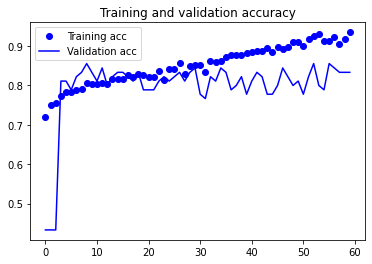

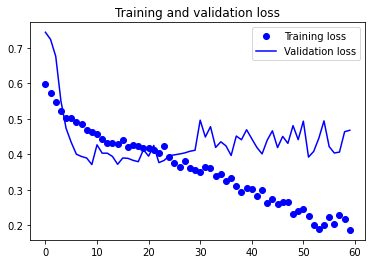

In [73]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = h.history['accuracy']
val_acc = h.history['val_accuracy']
loss = h.history['loss']
val_loss = h.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()